In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import pickle
import os

In [2]:
import plotting
import grids
import evolution

In [3]:
class RecSim():
    '''
    This is RecSim, a simulation class in Python for simulating the microphysics in liquid xenon to describe luminescence 
    from the recombination process.
    '''
    
    coord_names = np.array(['x', 'y', 'z'])      
    
    def __init__(self, coord_nbins, coord_stepsizes, dt, **config):
        '''
        Initialize simulation.
        '''
        
        # Set the bin steps and sizes
        self.coord_nbins = np.array(coord_nbins)
        self.coord_stepsizes = np.array(coord_stepsizes)
        self.dt = dt
        
        # Derived quantities
        self.bin_volume = np.product(self.coord_stepsizes)
        self.bin_surface = [self.bin_volume / stepsize for stepsize in self.coord_stepsizes]
        self.coord_range = self.coord_stepsizes * self.coord_nbins
        
            # Default parameters
        self.config = dict(
            # Fundamental quantities
            energy = 30., 
            W = 13.7e-3,
            ion_fraction = 1.,
            # Diffusion
            diffusion_e = True,
            e_diff_const = 6, # Diffusion constant in um^2/ns
            diffusion_ion = False,
            ion_diff_const = 0.,
            # Recombination
            recombination = True, 
            alpha=0.1, 
            # Drift
            drift_vector = np.array([0, 0, 1]),
            drift_e = False, 
            vd_e = 1.404, 
            drift_ion = False,
            vd_ion = - 0.,        # Set to negative value to account for different charge
            # Simulation settings
            max_outflow_fraction_warning = 0.5, max_n_errors = 5, 
            max_outflow_fraction_error = 1.,
            store_position = False,
            store_outflow_by_axis = False,
        )
        
        # Take additional settings. If specified in init, overwrite the default
        for key in self.config.keys():
            if key in config.keys():
                self.config[key] = config[key]
        # Input sanity checking
        for key in config:
            if key not in self.config.keys():
                print('Warning: unparsed argument %s will be ignored...' % key)
        
        if 'drift_vector' in config:
            if config['drift_vector'] == 'random':
                print('Randomizing drift vector...')
                self.config['drift_vector'] = random_three_vector()
            
                
        # Normalize the drift vector and make it a numpy array so that we can multiply later
        self.config['drift_vector'] = (np.array(self.config['drift_vector']) / 
                                       np.sqrt(np.sum(np.array(self.config['drift_vector']))))
        
        # Remove previous data
        self.d = []
        self.grids = {}
        self.t = 0.
        self.cumulative_drift = np.array([0.,0.,0.])
        self.n_errors = 0
        return

    def print_summary(self):
        d = self.data()
        print('================ SUMMARY OF SIMULATION ================')
        print('ELECTRON FATE')
        print('Escaped: %.1f %%' % (100. * np.sum(d['e_out']) / d['e_sum'].iloc[0]))
        return
      
    def data(self):
        return pd.DataFrame(self.d)
    
    def add_parameters(self):
        '''
        Produce a dict with time-dependent quantities
        '''
        ret = {}
        for name in ['e', 'ion']:            
            grid = self.grids[name]
            for i, coord in enumerate(self.coord_names):
                # POSITIONS
                if self.config['store_position']:
                    dist = np.sum(grid, axis = tuple([j for j in range(3) if i != j]))
                    ret[name + '_' + coord + '_median'] = np.where(
                        np.cumsum(dist) >= 0.5 * np.sum(dist))[0][0] * self.coord_stepsizes[i]
                    ret[name + '_' + coord + '_sigma'] = (
                        np.where(np.cumsum(dist) >= (1 - 0.68*0.5) * np.sum(dist))[0][0] -
                        np.where(np.cumsum(dist) >= (0.68*0.5) * np.sum(dist))[0][0])* self.coord_stepsizes[i]
                # CUMULATIVE
                ret['n_' + name] = self.integrate_grid(name)
                
        return ret
        
    def sanity_check(self):
        return
    
    def dump(self, folder = '/home/erik/win/data/recsimdata/', dumpname = 'dumpie'):
        if not os.path.isdir(folder):
            print('Save path %s does not exist, creating it...' % (folder))
            os.makedirs(folder)
        filename = os.path.join(folder, dumpname + '.pickle')
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        return
       
# Add all the functions from separate modules
for module in [plotting, grids, evolution]:
    for methodname in module.__all__:
        setattr(RecSim, methodname, getattr(module, methodname))

def recall(folder = '/home/erik/win/data/recsimdata/', dumpname = 'dumpie'):
    filename = os.path.join(folder, dumpname + '.pickle')
    if not os.path.isfile(filename):
        print('File %s does not exist, are you sure?' % filename)
        return
    with open(filename, 'rb') as f:
        self = pickle.load(f)
    return    

def random_three_vector():
    """
    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algo from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution
    :return:
    """
    phi = np.random.uniform(0,np.pi*2)
    costheta = np.random.uniform(-1,1)

    theta = np.arccos( costheta )
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = np.cos( theta )
    return (x,y,z)

In [4]:
rs = RecSim((41,41, 41), [1., 1., 1.], 
            dt=0.01, e_diff_const = 6., alpha = 1., drift_e = True, vd_e = 1.7, drift_vector=[0, 0,1], energy=22)

In [5]:
for species in ['e', 'ion']:
    rs.set_density_track(species, radius = 5, factor=100, mode='electrons')

In [6]:
rs.evolve(200)

2.00ns [00:02, 1.35s/ns, t=2]                             


In [7]:
rs.data()

,_maximum_relative_outflow,e_out,e_sum,ex_production,n_e,n_e_out,n_ex,n_ion,t
0,0.36,0.000000e+00,1607.209517,50.142450,1557.067067,0.000000e+00,50.142450,1557.067067,0.00
1,0.36,0.000000e+00,1557.067067,43.772331,1513.294736,0.000000e+00,93.914781,1513.294736,0.01
2,0.36,0.000000e+00,1513.294736,38.857720,1474.437016,0.000000e+00,132.772501,1474.437016,0.02
3,0.36,0.000000e+00,1474.437016,34.940994,1439.496022,0.000000e+00,167.713495,1439.496022,0.03
4,0.36,0.000000e+00,1439.496022,31.739051,1407.756971,0.000000e+00,199.452546,1407.756971,0.04
5,0.36,0.000000e+00,1407.756971,29.067142,1378.689829,0.000000e+00,228.519689,1378.689829,0.05
6,0.36,0.000000e+00,1378.689829,26.799550,1351.890279,0.000000e+00,255.319238,1351.890279,0.06
7,0.36,0.000000e+00,1351.890279,24.847762,1327.042517,0.000000e+00,280.167000,1327.042517,0.07
8,0.36,0.000000e+00,1327.042517,23.147667,1303.894851,0.000000e+00,303.314667,1303.894851,0.08
9,0.36,0.000000e+00,1303.894851,21.651683,1282.243168,0.000000e+00,324.966350,1282.243168,0.09


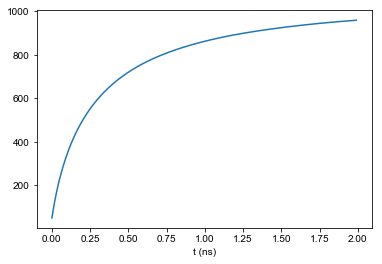

In [11]:
rs.plot_t('n_ex')

In [12]:
rs.decay_curve()

AttributeError: 'RecSim' object has no attribute 'decay_curve'